In [206]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Data loading and visualization

In [207]:
data = pd.read_csv('diabetes.csv')
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [208]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [209]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [210]:
# Check the class distribution to see if there is a class imbalance problem
print(data['Outcome'].value_counts()) 

Outcome
0    500
1    268
Name: count, dtype: int64


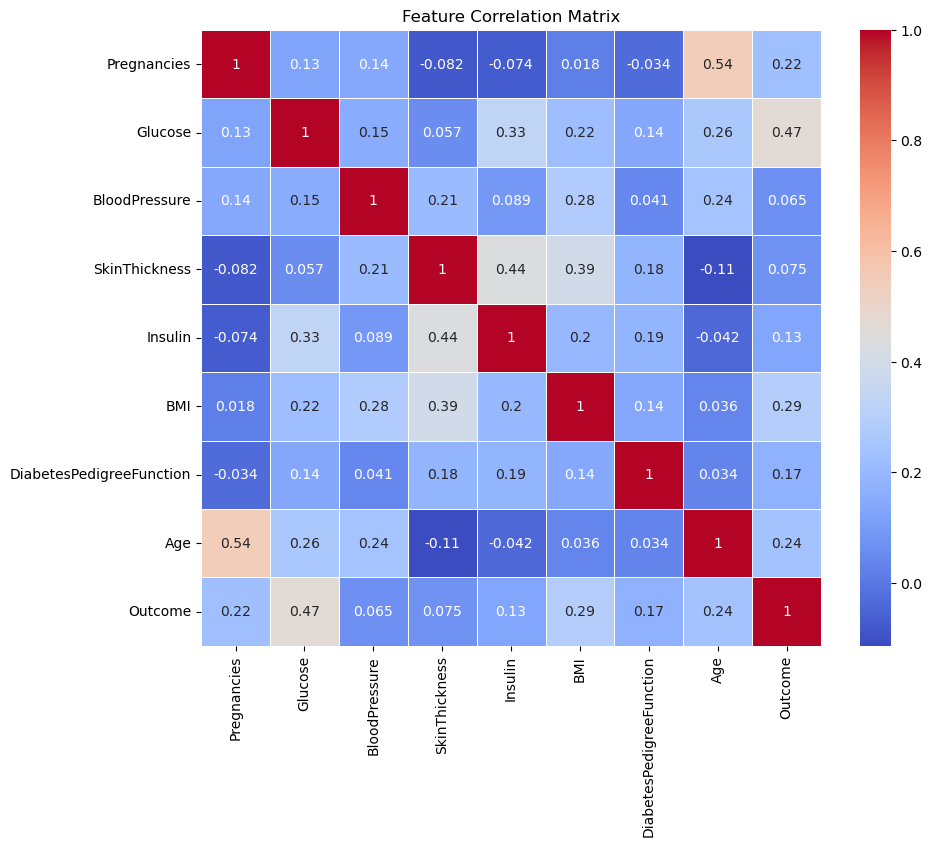

In [211]:
# Use Seaborn to draw a heat map to see the correlation between features
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()


# Data preprocessing and training set, validation set and test set segmentation and conversion into tensor variables

In [212]:
# data cleaning
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [213]:
# Extracting features and target variables
X = data.iloc[:, :-1].values
y = data['Outcome'].values    

In [214]:

# Oversampling with SMOTE to balance the dataset
smote = SMOTE(random_state = 42)
X, y = smote.fit_resample(X, y)


In [215]:
# Divide into training set, validation set and test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [216]:
# Feature Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [217]:
# Convert to PyTorch Tensor
X_train_torch = torch.FloatTensor(X_train)
y_train_torch = torch.FloatTensor(y_train)
X_val_torch = torch.FloatTensor(X_val)
y_val_torch = torch.FloatTensor(y_val)
X_test_torch = torch.FloatTensor(X_test)
y_test_torch = torch.FloatTensor(y_test)

# Creating custom datasets and data loaders
class DiabetesDatasetLoader(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
# 创建数据集和数据加载器
batch_size = 30
train_dataset = DiabetesDatasetLoader(X_train_torch, y_train_torch)
val_dataset = DiabetesDatasetLoader(X_val_torch, y_val_torch)
test_dataset = DiabetesDatasetLoader(X_test_torch, y_test_torch)

train_dataset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset_loader = DataLoader(val_dataset, batch_size=batch_size)
test_dataset_loader = DataLoader(test_dataset, batch_size=batch_size)
input_dim = X_train.shape[1] 


# 3. Baseline model

In [218]:
# Single-layer perceptron model (no hyperparameters)
class SingleLayerPerceptronBaseline(nn.Module):
    def __init__(self, input_dim):
        super(SingleLayerPerceptronBaseline, self).__init__()
        self.output = nn.Linear(input_dim, 1)  # Single-layer linear transformation
        self.activation = nn.Sigmoid()  # Use Sigmoid activation function for binary classification

    def forward(self, x):
        return self.activation(self.output(x))

# define the Baseline model and it loss function
model_baseline = SingleLayerPerceptronBaseline(input_dim)
criterion = nn.BCELoss()

In [219]:
# Without using the optimizer, the weights are updated manually
epochs = 500
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model = None

# Baseline model training loop
for epoch in range(epochs):
    model_baseline.train()
    total_train_loss = 0.0
    for inputs, labels in train_dataset_loader:
        # Forward Propagation
        outputs = model_baseline(inputs)
        loss = criterion(outputs, labels.view(-1, 1))

        # Backpropagation, manual weight update (no learning rate)
        loss.backward()
        with torch.no_grad():
            for param in model_baseline.parameters():
                param -= param.grad
        model_baseline.zero_grad()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataset_loader)
    train_losses.append(avg_train_loss)

    # Validate the model
    model_baseline.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dataset_loader:
            outputs = model_baseline(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataset_loader)
    val_losses.append(avg_val_loss)

    # Save the model with the lowest validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = model_baseline.state_dict()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')


Epoch [100/500], Training Loss: 0.5053, Validation Loss: 0.4890
Epoch [200/500], Training Loss: 0.5049, Validation Loss: 0.4856
Epoch [300/500], Training Loss: 0.5064, Validation Loss: 0.4977
Epoch [400/500], Training Loss: 0.5045, Validation Loss: 0.5168
Epoch [500/500], Training Loss: 0.5007, Validation Loss: 0.4983


In [220]:
# Use test_set for test set evaluation
model_baseline.load_state_dict(best_model)  # Loading optimal model parameters
model_baseline.eval()

test_accuracy = 0.0
TP, TN, FP, FN = 0, 0, 0, 0

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_dataset_loader:
    
        y_pred_test = (model_baseline(inputs) >= 0.5).float().view(-1)
        
        # Calculate the batch accuracy
        test_accuracy += torch.sum(y_pred_test == labels).item()

        # Calculate the elements in the confusion matrix
        TP += torch.sum((y_pred_test == 1) & (labels == 1)).item()
        TN += torch.sum((y_pred_test == 0) & (labels == 0)).item()
        FP += torch.sum((y_pred_test == 1) & (labels == 0)).item()
        FN += torch.sum((y_pred_test == 0) & (labels == 1)).item()

# Calculate the accuracy of the entire test set
test_accuracy /= len(test_dataset)

# Calculate the confusion matrix
confusion_matrix_test = torch.tensor([[TN, FP], [FN, TP]])

# Calculate precision, recall, and F1 score
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# 打印结果
print(f'Baseline model test accuracy: {test_accuracy * 100:.2f}%')
print(f'Baseline model test precision: {precision:.4f}')
print(f'Baseline model test recall: {recall:.4f}')
print(f'Baseline model test F1-score: {f1_score:.4f}')


Baseline model test accuracy: 74.50%
Baseline model test precision: 0.7579
Baseline model test recall: 0.7200
Baseline model test F1-score: 0.7385


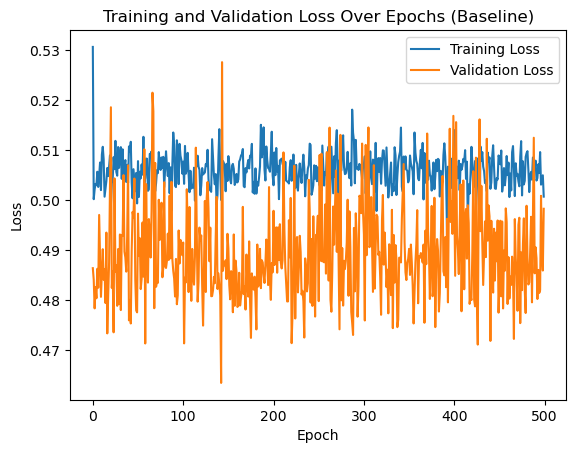

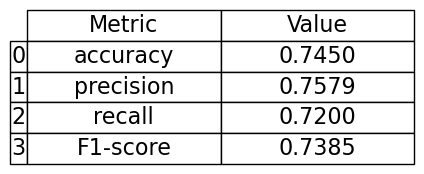

In [221]:
# Plotting the loss curve
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs (Baseline)')
plt.legend()
plt.show()

# Draw the result table
result_data = {
    'Metric': ['accuracy', 'precision', 'recall', 'F1-score'],
    'Value': [f'{test_accuracy :.4f}', f'{precision:.4f}', f'{recall:.4f}', f'{f1_score:.4f}']
}

df = pd.DataFrame(result_data)
fig, ax = plt.subplots(figsize=(5, 2))
ax.axis('tight')
ax.axis('off')

table = pd.plotting.table(ax, df, loc='center', cellLoc='center', colWidths=[0.4, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(16)
for key, cell in table.get_celld().items():
    cell.set_height(0.2)
    cell.set_width(0.5)
plt.show()


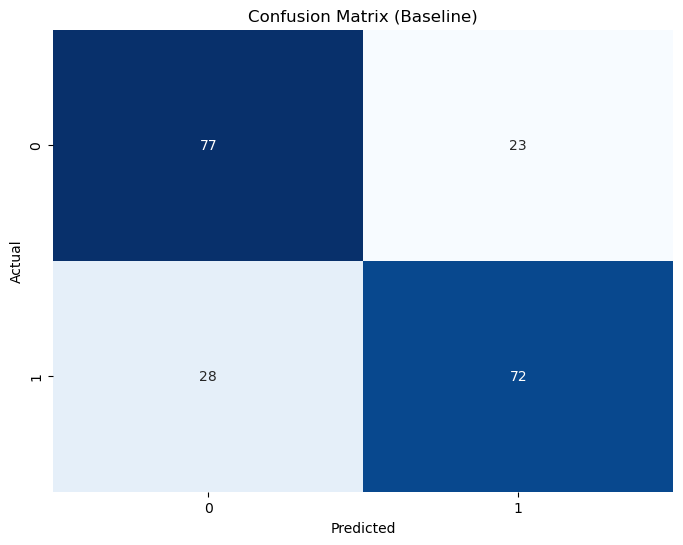

In [222]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Baseline)')
plt.show()

# Enhance Model

In [223]:
# Define a enhance single-layer perceptron model
class SingleLayerPerceptron(nn.Module):
    def __init__(self, input_dim):
        super(SingleLayerPerceptron, self).__init__()
        self.output = nn.Linear(input_dim, 1)  
        self.activation = nn.Sigmoid()

    def forward(self, x):
        out = self.output(x)
        return torch.sigmoid(out)

In [224]:
model = SingleLayerPerceptron(input_dim)  # Initialize the model

# Defining loss function and optimizer
criterion = nn.BCELoss()  # Binary cross entropy loss, for binary classification tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Use the Adam optimizer with a learning rate and add L2 regularization


In [225]:
# Train the model and save the optimal model
epochs = 500 
train_losses = [] 
val_losses = []
best_val_loss = float('inf')
best_model = None

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    for inputs, labels in train_dataset_loader:
        optimizer.zero_grad()
        outputs = model(inputs) 
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_dataset_loader)
    train_losses.append(avg_train_loss)

    # Validate the model
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dataset_loader:
            outputs = model(inputs) 
            loss = criterion(outputs, labels.view(-1, 1)) 
            total_val_loss += loss.item() 
    
    avg_val_loss = total_val_loss / len(val_dataset_loader)  
    val_losses.append(avg_val_loss) 

    # Save the model with the lowest validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = model.state_dict()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

Epoch [100/500], Training Loss: 0.4912, Validation Loss: 0.4806
Epoch [200/500], Training Loss: 0.4889, Validation Loss: 0.4809
Epoch [300/500], Training Loss: 0.4888, Validation Loss: 0.4812
Epoch [400/500], Training Loss: 0.4888, Validation Loss: 0.4811
Epoch [500/500], Training Loss: 0.4888, Validation Loss: 0.4811


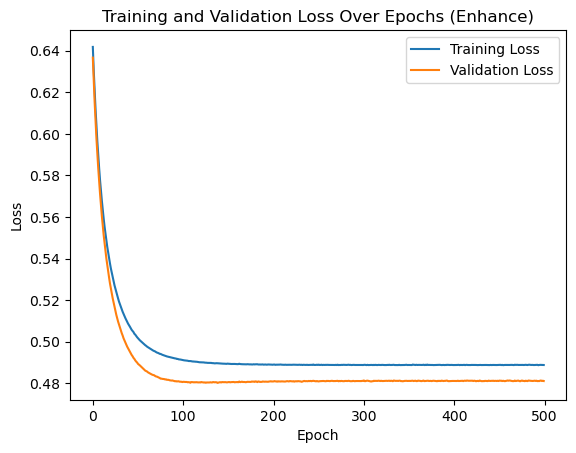

In [226]:
# Plotting training and validation loss curves
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs (Enhance)')
plt.legend()
plt.show()

In [227]:
# Use the best model with test_data
model.eval()
test_accuracy = 0.0
TP, TN, FP, FN = 0, 0, 0, 0

with torch.no_grad():
    for inputs, labels in test_dataset_loader:
        
        y_pred_test = (model(inputs) >= 0.5).float().view(-1)
        
        test_accuracy += torch.sum(y_pred_test == labels).item()

        TP += torch.sum((y_pred_test == 1) & (labels == 1)).item() 
        TN += torch.sum((y_pred_test == 0) & (labels == 0)).item() 
        FP += torch.sum((y_pred_test == 1) & (labels == 0)).item() 
        FN += torch.sum((y_pred_test == 0) & (labels == 1)).item() 

# Calculate the overall accuracy of the test set
test_accuracy /= len(test_dataset)

# Confusion Matrix
confusion_matrix_test = torch.tensor([[TN, FP], [FN, TP]])

# Calculate precision, recall, and F1 score
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f'Enhance model test accuracy: {test_accuracy * 100:.2f}%')
print(f'Enhance model test precision: {precision:.4f}')
print(f'Enhance model test recall: {recall:.4f}')
print(f'Enhance model test F1-Score: {f1_score:.4f}')


Enhance model test accuracy: 75.00%
Enhance model test precision: 0.7604
Enhance model test recall: 0.7300
Enhance model test F1-Score: 0.7449


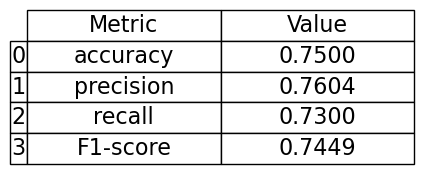

In [228]:
# Metrics results
result_data = {
    'Metric': ['accuracy', 'precision', 'recall', 'F1-score'],
    'Value': [f'{test_accuracy :.4f}', f'{precision:.4f}', f'{recall:.4f}', f'{f1_score:.4f}']
}

# Create DataFrame
df = pd.DataFrame(result_data)

# Plotting the table using pandas and matplotlib
fig, ax = plt.subplots(figsize=(5, 2))  # Create a new figure with specified size
ax.axis('tight')
ax.axis('off')

# Create the table
table = pd.plotting.table(ax, df, loc='center', cellLoc='center', colWidths=[0.4, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(16)
# Adjust row height for better visibility
for key, cell in table.get_celld().items():
    cell.set_height(0.2)
    cell.set_width(0.5)
# Display the table
plt.show()



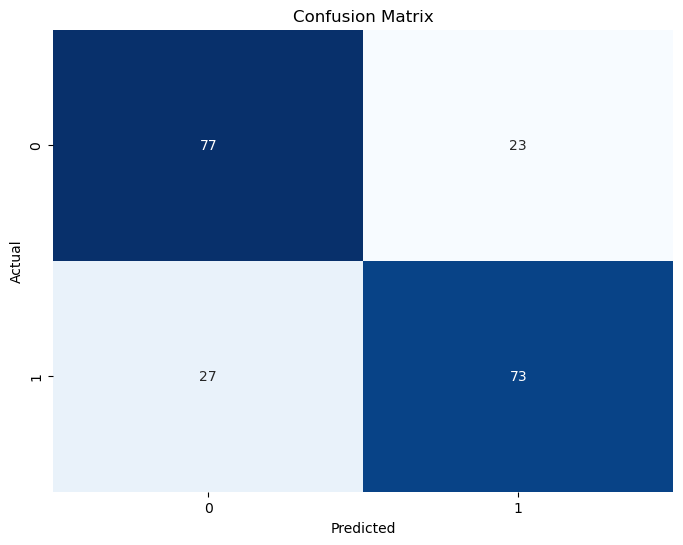

In [229]:
# Display the confusion matrix graphically
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

